# Spectrum filtering + delta/sigma

Let's try with different components of the spectrum to see how do they contribute to the signal

In [202]:
import glob
import numpy as np
from scipy import fftpack
import pandas as pnd
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages


In [203]:
folders = ['0_setup_protons',
'1_protons_1e11_both_ch',
'2_protons_1e11_ch1_high_BW',
'3_protons_1e11_both_untiltheend',
'4_electrons_600pC_ch1_high_BW',
'5_electrons_600pC_ch1_both_ch',
'6_electrons_steering_both_ch_reference',
'7_electrons_steering_both_ch_-5mm',
'8_electrons_steering_both_ch_0',
'9_electrons_steering_both_ch_+5mm',
'10_protons_2e11_2ch',
'11_protons_2e11_ch1_high_BW',
'12_protons+electrons_2ch_simultaneous',
'13_protons+electrons_ch1_simultaneous',
'14_protons+electrons_2ch_simultaneous_electron_bump+5mm',
'15_protons+electrons_2ch_simultaneous_electron_bump-5mm',
'16_protons+electrons_1ch_simultaneous_electron_bump-5mm',
'17_protons+electrons_1ch_simultaneous_electron_bump_in_centre',
'18_protons+electrons_1ch_simultaneous_electron_bump+5mm',
'19_electrons_ahead_3ns_zoom',
'20_electrons_ahead_2ch',
'21_electrons_ahead_3ns_ch1',
'22_electrons_behind_3ns_2ch',
'23_electrons_behind_3ns_ch1',
'24_until_the_last_proton_beam_alone_2ch']

paths = ['./data/'+f+'/*.txt' for f in folders]

files = [sorted(glob.glob(p)) for p in paths]

In [204]:
def gimme(data_path, header_len=5):
    '''
    Produce the output of the single file analysis:
    
    data_path: the file including path
    
    data[0]: the timescale of the trace
    data[1]: the signal of the trace
    t_sampl: the sampling time
    freqs: the FFT frequency scale (the x axis in practice)
    f_spectrum_complex: the FFT output. Complex numbers.
    f_spectrum_abs: the FFT output. Complex numbers.

    '''
    data = np.loadtxt(data_path, delimiter=' ', skiprows=header_len)
    data = data.transpose()
    t_sampl = data[0][1]-data[0][0]
    
    f_spectrum_complex = fftpack.fft(data[1])
    freqs = fftpack.fftfreq(data[1].size, d=t_sampl )
        
    return data[0], data[1], t_sampl, freqs, f_spectrum_complex


def apply_bandpass_filter(freqs, f_spectrum, flow, fhi):
    ss = f_spectrum.copy()
    bool_idx =  np.logical_or(np.logical_and(freqs>flow, freqs<fhi), np.logical_and(freqs<-flow, freqs>-fhi))
    ss[~bool_idx] = 0.
    return ss

def dB(x):
    return 20*np.log10(x)

def interp_ch1(t_ch2, t_ch1, signal_ch1):
    return np.interp(t_ch2, t_ch1, signal_ch1)

def delta_sigma_rms(x1, x2):
    x1rms = np.std(x1)
    x2rms = np.std(x2)
    return (x1rms-x2rms)/(x1rms+x2rms)

# Protons

In [128]:
p_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
p_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])

In [129]:
off = 12
k=0
name = '0'
for k in range(off):
    name=str(k)
    p_df_ch1.loc[name] = gimme(files[1][k])
    p_df_ch2.loc[name] = gimme(files[1][off+k])


In [130]:
# build the dataframe with both channels
pdf = pnd.concat([p_df_ch1,p_df_ch2],sort=False,axis=1)

In [8]:
# apply the basnpass filters
pdf['CH1_FFT_filter1'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 0., 1.25e9),axis=1)
pdf['CH1_V_ifft1'] = pdf['CH1_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
pdf['CH2_FFT_filter1'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 0., 1.25e9),axis=1)
pdf['CH2_V_ifft1'] = pdf['CH2_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
                               
pdf['CH1_FFT_filter2'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
pdf['CH1_V_ifft2'] = pdf['CH1_FFT_filter2'].apply(lambda x: fftpack.ifft(x))
pdf['CH2_FFT_filter2'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
pdf['CH2_V_ifft2'] = pdf['CH2_FFT_filter2'].apply(lambda x: fftpack.ifft(x))

pdf['CH1_FFT_filter3'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
pdf['CH1_V_ifft3'] = pdf['CH1_FFT_filter3'].apply(lambda x: fftpack.ifft(x))
pdf['CH2_FFT_filter3'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
pdf['CH2_V_ifft3'] = pdf['CH2_FFT_filter3'].apply(lambda x: fftpack.ifft(x))

pdf['CH1_FFT_filter4'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 3.5e9, 7e9),axis=1)
pdf['CH1_V_ifft4'] = pdf['CH1_FFT_filter4'].apply(lambda x: fftpack.ifft(x))
pdf['CH2_FFT_filter4'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 3.5e9, 7e9),axis=1)
pdf['CH2_V_ifft4'] = pdf['CH2_FFT_filter4'].apply(lambda x: fftpack.ifft(x))

pdf['CH1_FFT_filter5'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 7e9, 12e9),axis=1)
pdf['CH1_V_ifft5'] = pdf['CH1_FFT_filter5'].apply(lambda x: fftpack.ifft(x))
pdf['CH2_FFT_filter5'] = pdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 7e9, 12e9),axis=1)
pdf['CH2_V_ifft5'] = pdf['CH2_FFT_filter5'].apply(lambda x: fftpack.ifft(x))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


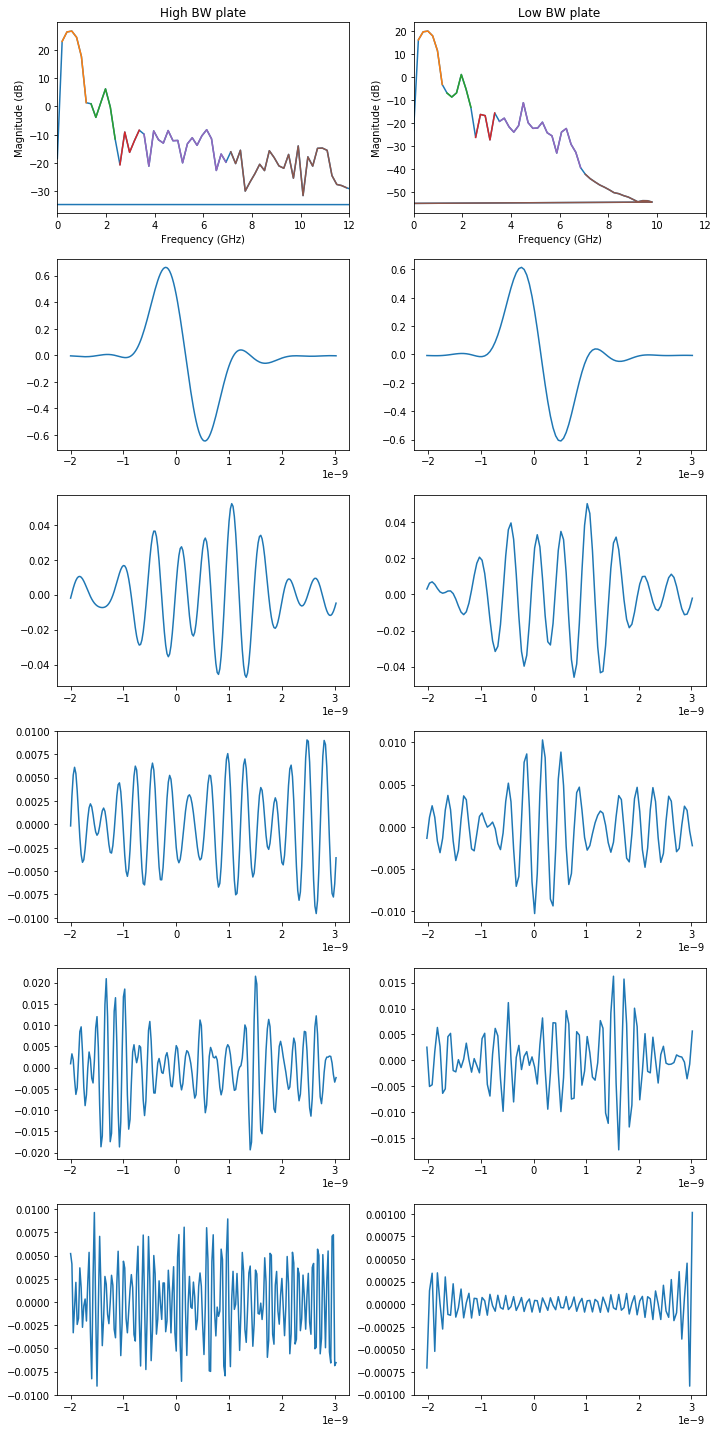

In [10]:
fig, ax = plt.subplots(6, 2, figsize=(10,20))

k = 2 # shot number

ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_magnitude'].iloc[k])))
ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_filter1'].iloc[k])))
ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_filter2'].iloc[k])))
ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_filter3'].iloc[k])))
ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_filter4'].iloc[k])))
ax[0,0].plot(1e-9*pdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH1_FFT_filter5'].iloc[k])))
ax[0,0].set_xlabel('Frequency (GHz)')
ax[0,0].set_ylabel('Magnitude (dB)')
ax[0,0].set_xlim(0,12)
ax[0,0].set_title('High BW plate')

ax[1,0].plot(pdf['CH1_t'].iloc[k], pdf['CH1_V_ifft1'].iloc[k])
ax[2,0].plot(pdf['CH1_t'].iloc[k], pdf['CH1_V_ifft2'].iloc[k])
ax[3,0].plot(pdf['CH1_t'].iloc[k], pdf['CH1_V_ifft3'].iloc[k])
ax[4,0].plot(pdf['CH1_t'].iloc[k], pdf['CH1_V_ifft4'].iloc[k])
ax[5,0].plot(pdf['CH1_t'].iloc[k], pdf['CH1_V_ifft5'].iloc[k])

ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_magnitude'].iloc[k])))
ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_filter1'].iloc[k])))
ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_filter2'].iloc[k])))
ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_filter3'].iloc[k])))
ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_filter4'].iloc[k])))
ax[0,1].plot(1e-9*pdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(pdf['CH2_FFT_filter5'].iloc[k])))
ax[0,1].set_xlabel('Frequency (GHz)')
ax[0,1].set_ylabel('Magnitude (dB)')
ax[0,1].set_xlim(0,12)
ax[0,1].set_title('Low BW plate')

ax[1,1].plot(pdf['CH2_t'].iloc[k], pdf['CH2_V_ifft1'].iloc[k])
ax[2,1].plot(pdf['CH2_t'].iloc[k], pdf['CH2_V_ifft2'].iloc[k])
ax[3,1].plot(pdf['CH2_t'].iloc[k], pdf['CH2_V_ifft3'].iloc[k])
ax[4,1].plot(pdf['CH2_t'].iloc[k], pdf['CH2_V_ifft4'].iloc[k])
ax[5,1].plot(pdf['CH2_t'].iloc[k], pdf['CH2_V_ifft5'].iloc[k])
ax[0,0].set_title('High BW plate')


fig.tight_layout()

In [20]:
# good, now let's interpolate CH1 to the CH2 acquisition 
pdf['CH1_V_interp'] = pdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V']),axis=1)
pdf['CH1_V_interp_filter1'] = pdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft1']),axis=1)
pdf['CH1_V_interp_filter2'] = pdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft2']),axis=1)
pdf['CH1_V_interp_filter3'] = pdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft3']),axis=1)

In [46]:
# an attempt for delta/sigma using the rms --> no need of the interpolation but assume that the two ADCs are the same
pdf['delta/sigma'] = pdf.apply(lambda row: delta_sigma_rms(row['CH1_V']), axis=1)


# Electrons

In [199]:
# electrons in the centre
e_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
e_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 101
k=0
for k in range(off):
    name=str(k)
    e_df_ch1.loc[name] = gimme(files[5][k])
    e_df_ch2.loc[name] = gimme(files[5][off+k])

edf1 = pnd.concat([e_df_ch1,e_df_ch2],axis=1)
edf1['position_set'] = 0.

# electrons -5mm
e_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
e_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 59
k=0
for k in range(off):
    name=str(k+len(edf1))
    e_df_ch1.loc[name] = gimme(files[7][k])
    e_df_ch2.loc[name] = gimme(files[7][off+k])

edf2 = pnd.concat([e_df_ch1,e_df_ch2],axis=1)
edf2['position_set'] = -5.

# electrons +5mm
e_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
e_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 97
k=0
for k in range(off):
    name=str(k+len(edf1)+len(edf2))
    e_df_ch1.loc[name] = gimme(files[9][k])
    e_df_ch2.loc[name] = gimme(files[9][off+k])

edf3 = pnd.concat([e_df_ch1,e_df_ch2],axis=1)
edf3['position_set'] = 5.

In [135]:
# aggregate to build the dataframe
edf = edf1.append(edf2)
edf = edf.append(edf3)

In [140]:
# apply the basnpass filters
edf['CH1_FFT_filter1'] = edf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 0., 1.25e9),axis=1)
edf['CH1_V_ifft1'] = edf['CH1_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
edf['CH2_FFT_filter1'] = edf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 0., 1.25e9),axis=1)
edf['CH2_V_ifft1'] = edf['CH2_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
                               
edf['CH1_FFT_filter2'] = edf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
edf['CH1_V_ifft2'] = edf['CH1_FFT_filter2'].apply(lambda x: fftpack.ifft(x))
edf['CH2_FFT_filter2'] = edf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
edf['CH2_V_ifft2'] = edf['CH2_FFT_filter2'].apply(lambda x: fftpack.ifft(x))

edf['CH1_FFT_filter3'] = edf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
edf['CH1_V_ifft3'] = edf['CH1_FFT_filter3'].apply(lambda x: fftpack.ifft(x))
edf['CH2_FFT_filter3'] = edf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
edf['CH2_V_ifft3'] = edf['CH2_FFT_filter3'].apply(lambda x: fftpack.ifft(x))

edf['CH1_FFT_filter4'] = edf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 3.5e9, 7e9),axis=1)
edf['CH1_V_ifft4'] = edf['CH1_FFT_filter4'].apply(lambda x: fftpack.ifft(x))
edf['CH2_FFT_filter4'] = edf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 3.5e9, 7e9),axis=1)
edf['CH2_V_ifft4'] = edf['CH2_FFT_filter4'].apply(lambda x: fftpack.ifft(x))

edf['CH1_FFT_filter5'] = edf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 7e9, 12e9),axis=1)
edf['CH1_V_ifft5'] = edf['CH1_FFT_filter5'].apply(lambda x: fftpack.ifft(x))
edf['CH2_FFT_filter5'] = edf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 7e9, 12e9),axis=1)
edf['CH2_V_ifft5'] = edf['CH2_FFT_filter5'].apply(lambda x: fftpack.ifft(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


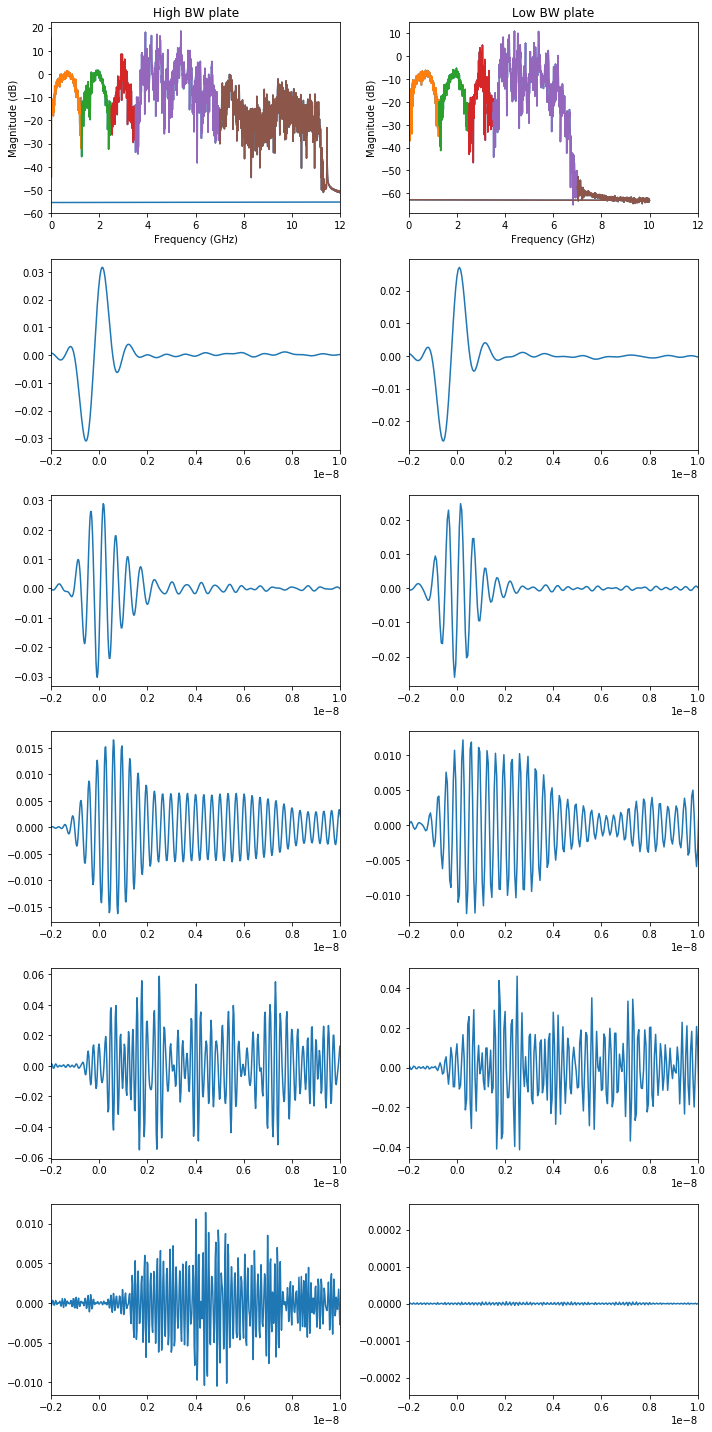

In [144]:
fig, ax = plt.subplots(6, 2, figsize=(10,20))

k = 2 # shot number

ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_magnitude'].iloc[k])))
ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_filter1'].iloc[k])))
ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_filter2'].iloc[k])))
ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_filter3'].iloc[k])))
ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_filter4'].iloc[k])))
ax[0,0].plot(1e-9*edf['CH1_FFT_freqs'].iloc[k], dB(np.abs(edf['CH1_FFT_filter5'].iloc[k])))
ax[0,0].set_xlabel('Frequency (GHz)')
ax[0,0].set_ylabel('Magnitude (dB)')
ax[0,0].set_xlim(0,12)
ax[0,0].set_title('High BW plate')

ax[1,0].plot(edf['CH1_t'].iloc[k], edf['CH1_V_ifft1'].iloc[k])
ax[2,0].plot(edf['CH1_t'].iloc[k], edf['CH1_V_ifft2'].iloc[k])
ax[3,0].plot(edf['CH1_t'].iloc[k], edf['CH1_V_ifft3'].iloc[k])
ax[4,0].plot(edf['CH1_t'].iloc[k], edf['CH1_V_ifft4'].iloc[k])
ax[5,0].plot(edf['CH1_t'].iloc[k], edf['CH1_V_ifft5'].iloc[k])
[ax[ll,0].set_xlim(-0.02e-7,0.1e-7) for ll in [1,2,3,4,5]]

ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_magnitude'].iloc[k])))
ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_filter1'].iloc[k])))
ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_filter2'].iloc[k])))
ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_filter3'].iloc[k])))
ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_filter4'].iloc[k])))
ax[0,1].plot(1e-9*edf['CH2_FFT_freqs'].iloc[k], dB(np.abs(edf['CH2_FFT_filter5'].iloc[k])))
ax[0,1].set_xlabel('Frequency (GHz)')
ax[0,1].set_ylabel('Magnitude (dB)')
ax[0,1].set_xlim(0,12)
ax[0,1].set_title('Low BW plate')

ax[1,1].plot(edf['CH2_t'].iloc[k], edf['CH2_V_ifft1'].iloc[k])
ax[2,1].plot(edf['CH2_t'].iloc[k], edf['CH2_V_ifft2'].iloc[k])
ax[3,1].plot(edf['CH2_t'].iloc[k], edf['CH2_V_ifft3'].iloc[k])
ax[4,1].plot(edf['CH2_t'].iloc[k], edf['CH2_V_ifft4'].iloc[k])
ax[5,1].plot(edf['CH2_t'].iloc[k], edf['CH2_V_ifft5'].iloc[k])
ax[0,0].set_title('High BW plate')
[ax[ll,1].set_xlim(-0.02e-7,0.1e-7) for ll in [1,2,3,4,5]]



fig.tight_layout()

In [145]:
# good, now let's interpolate CH1 to the CH2 acquisition 
edf['CH1_V_interp'] = edf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V']),axis=1)
edf['CH1_V_interp_filter1'] = edf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft1']),axis=1)
edf['CH1_V_interp_filter2'] = edf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft2']),axis=1)
edf['CH1_V_interp_filter3'] = edf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft3']),axis=1)

In [162]:
# an attempt for delta/sigma using the rms --> no need of the interpolation but assume that the two ADCs are the same
edf['delta/sigma'] = edf.apply(lambda row: delta_sigma_rms(row['CH1_V'], row['CH2_V']), axis=1)
edf['delta/sigma_filter1'] = edf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft1'], row['CH2_V_ifft1']), axis=1)
edf['delta/sigma_filter2'] = edf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft2'], row['CH2_V_ifft2']), axis=1)
edf['delta/sigma_filter3'] = edf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft3'], row['CH2_V_ifft3']), axis=1)
edf['delta/sigma_filter4'] = edf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft4'], row['CH2_V_ifft4']), axis=1)


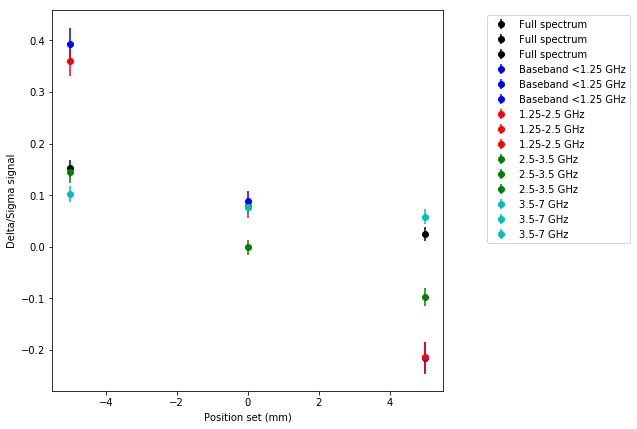

In [191]:
# no intensity normalisation
fig, ax = plt.subplots(1, figsize=(7,7))
def errordata(position, filter_str):
    mean = np.mean(edf[filter_str].loc[edf['position_set']==position])
    devsta = np.std(edf[filter_str].loc[edf['position_set']==position])
    return mean, devsta

for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma'), fmt='o', label='Full spectrum', color='k')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter1'), fmt='o', label='Baseband <1.25 GHz', color='b')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter2'), fmt='o', label='1.25-2.5 GHz', color='r')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter3'), fmt='o', label='2.5-3.5 GHz', color='g')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter4'), fmt='o', label='3.5-7 GHz', color='c')


ax.set_xlabel('Position set (mm)')
ax.set_ylabel('Delta/Sigma signal')

# ax.plot(edf['position_set'],edf['delta/sigma_filter1'],'.', label='Baseband <1.25 GHz')
# ax.plot(edf['position_set'],edf['delta/sigma_filter2'],'.', label='1.25-2.5 GHz')
# ax.plot(edf['position_set'],edf['delta/sigma_filter3'],'.', label='2.5-3.5 GHz')
# ax.plot(edf['position_set'],edf['delta/sigma_filter4'],'.', label='3.5-7 GHz')



ax.legend(frameon=True,bbox_to_anchor=(1.1,1))

# Electrons + protons

In [223]:
# electrons in the centre
ep_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
ep_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 10
k=0
for k in range(off):
    name=str(k)
    ep_df_ch1.loc[name] = gimme(files[12][k])
    ep_df_ch2.loc[name] = gimme(files[12][off+k])

epdf1 = pnd.concat([ep_df_ch1,ep_df_ch2],axis=1)
epdf1['position_set'] = 0.

# electrons -5mm
ep_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
ep_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 10
k=0
for k in range(off):
    name=str(k+len(epdf1))
    ep_df_ch1.loc[name] = gimme(files[14][k])
    ep_df_ch2.loc[name] = gimme(files[14][off+k])

epdf2 = pnd.concat([ep_df_ch1,ep_df_ch2],axis=1)
epdf2['position_set'] = 5.

# electrons +5mm
ep_df_ch1 = pnd.DataFrame([],columns=['CH1_t','CH1_V','CH1_t_sampling','CH1_FFT_freqs','CH1_FFT_magnitude'])
ep_df_ch2 = pnd.DataFrame([],columns=['CH2_t','CH2_V','CH2_t_sampling','CH2_FFT_freqs','CH2_FFT_magnitude'])
off = 10
k=0
for k in range(off):
    name=str(k+len(epdf1)+len(epdf2))
    ep_df_ch1.loc[name] = gimme(files[15][k])
    ep_df_ch2.loc[name] = gimme(files[15][off+k])

epdf3 = pnd.concat([ep_df_ch1,ep_df_ch2],axis=1)
epdf3['position_set'] = -5.

In [224]:
# aggregate to build the dataframe
epdf = epdf1.append(epdf2)
epdf = epdf.append(epdf3)

In [225]:
# apply the basnpass filters
epdf['CH1_FFT_filter1'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 0., 1.25e9),axis=1)
epdf['CH1_V_ifft1'] = epdf['CH1_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
epdf['CH2_FFT_filter1'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 0., 1.25e9),axis=1)
epdf['CH2_V_ifft1'] = epdf['CH2_FFT_filter1'].apply(lambda x: fftpack.ifft(x))
                               
epdf['CH1_FFT_filter2'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
epdf['CH1_V_ifft2'] = epdf['CH1_FFT_filter2'].apply(lambda x: fftpack.ifft(x))
epdf['CH2_FFT_filter2'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 1.25e9, 2.5e9),axis=1)
epdf['CH2_V_ifft2'] = epdf['CH2_FFT_filter2'].apply(lambda x: fftpack.ifft(x))

epdf['CH1_FFT_filter3'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
epdf['CH1_V_ifft3'] = epdf['CH1_FFT_filter3'].apply(lambda x: fftpack.ifft(x))
epdf['CH2_FFT_filter3'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 2.5e9, 3.5e9),axis=1)
epdf['CH2_V_ifft3'] = epdf['CH2_FFT_filter3'].apply(lambda x: fftpack.ifft(x))

epdf['CH1_FFT_filter4'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 3.5e9, 7e9),axis=1)
epdf['CH1_V_ifft4'] = epdf['CH1_FFT_filter4'].apply(lambda x: fftpack.ifft(x))
epdf['CH2_FFT_filter4'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 3.5e9, 7e9),axis=1)
epdf['CH2_V_ifft4'] = epdf['CH2_FFT_filter4'].apply(lambda x: fftpack.ifft(x))

epdf['CH1_FFT_filter5'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH1_FFT_freqs'], row['CH1_FFT_magnitude'], 7e9, 12e9),axis=1)
epdf['CH1_V_ifft5'] = epdf['CH1_FFT_filter5'].apply(lambda x: fftpack.ifft(x))
epdf['CH2_FFT_filter5'] = epdf.apply(lambda row: apply_bandpass_filter(row['CH2_FFT_freqs'], row['CH2_FFT_magnitude'], 7e9, 12e9),axis=1)
epdf['CH2_V_ifft5'] = epdf['CH2_FFT_filter5'].apply(lambda x: fftpack.ifft(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


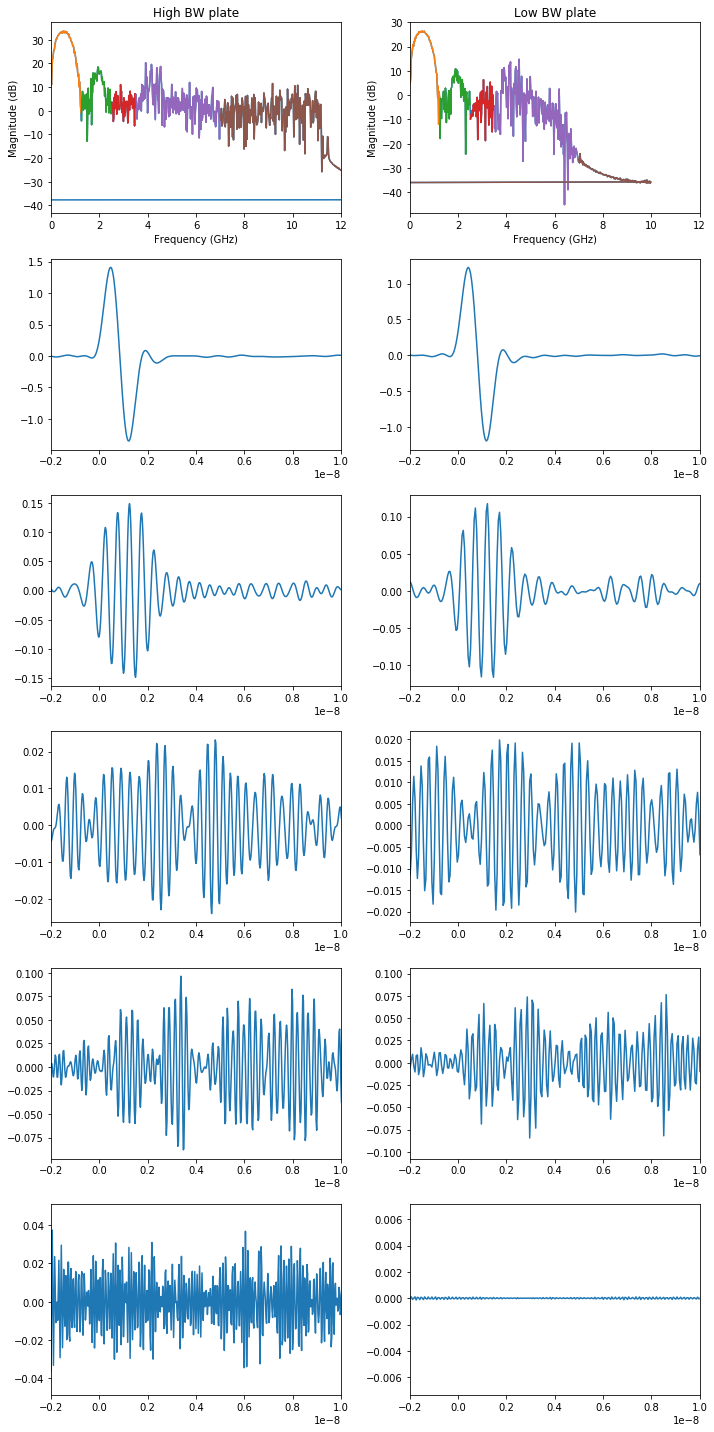

In [226]:
fig, ax = plt.subplots(6, 2, figsize=(10,20))

k = 2 # shot number

ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_magnitude'].iloc[k])))
ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_filter1'].iloc[k])))
ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_filter2'].iloc[k])))
ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_filter3'].iloc[k])))
ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_filter4'].iloc[k])))
ax[0,0].plot(1e-9*epdf['CH1_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH1_FFT_filter5'].iloc[k])))
ax[0,0].set_xlabel('Frequency (GHz)')
ax[0,0].set_ylabel('Magnitude (dB)')
ax[0,0].set_xlim(0,12)
ax[0,0].set_title('High BW plate')

ax[1,0].plot(epdf['CH1_t'].iloc[k], epdf['CH1_V_ifft1'].iloc[k])
ax[2,0].plot(epdf['CH1_t'].iloc[k], epdf['CH1_V_ifft2'].iloc[k])
ax[3,0].plot(epdf['CH1_t'].iloc[k], epdf['CH1_V_ifft3'].iloc[k])
ax[4,0].plot(epdf['CH1_t'].iloc[k], epdf['CH1_V_ifft4'].iloc[k])
ax[5,0].plot(epdf['CH1_t'].iloc[k], epdf['CH1_V_ifft5'].iloc[k])
[ax[ll,0].set_xlim(-0.02e-7,0.1e-7) for ll in [1,2,3,4,5]]

ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_magnitude'].iloc[k])))
ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_filter1'].iloc[k])))
ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_filter2'].iloc[k])))
ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_filter3'].iloc[k])))
ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_filter4'].iloc[k])))
ax[0,1].plot(1e-9*epdf['CH2_FFT_freqs'].iloc[k], dB(np.abs(epdf['CH2_FFT_filter5'].iloc[k])))
ax[0,1].set_xlabel('Frequency (GHz)')
ax[0,1].set_ylabel('Magnitude (dB)')
ax[0,1].set_xlim(0,12)
ax[0,1].set_title('Low BW plate')

ax[1,1].plot(epdf['CH2_t'].iloc[k], epdf['CH2_V_ifft1'].iloc[k])
ax[2,1].plot(epdf['CH2_t'].iloc[k], epdf['CH2_V_ifft2'].iloc[k])
ax[3,1].plot(epdf['CH2_t'].iloc[k], epdf['CH2_V_ifft3'].iloc[k])
ax[4,1].plot(epdf['CH2_t'].iloc[k], epdf['CH2_V_ifft4'].iloc[k])
ax[5,1].plot(epdf['CH2_t'].iloc[k], epdf['CH2_V_ifft5'].iloc[k])
ax[0,0].set_title('High BW plate')
[ax[ll,1].set_xlim(-0.02e-7,0.1e-7) for ll in [1,2,3,4,5]]



fig.tight_layout()

In [227]:
# good, now let's interpolate CH1 to the CH2 acquisition 
epdf['CH1_V_interp'] = epdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V']),axis=1)
epdf['CH1_V_interp_filter1'] = epdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft1']),axis=1)
epdf['CH1_V_interp_filter2'] = epdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft2']),axis=1)
epdf['CH1_V_interp_filter3'] = epdf.apply(lambda row: interp_ch1(row['CH2_t'], row['CH1_t'], row['CH1_V_ifft3']),axis=1)

In [228]:
# an attempt for delta/sigma using the rms --> no need of the interpolation but assume that the two ADCs are the same
epdf['delta/sigma'] = epdf.apply(lambda row: delta_sigma_rms(row['CH1_V'], row['CH2_V']), axis=1)
epdf['delta/sigma_filter1'] = epdf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft1'], row['CH2_V_ifft1']), axis=1)
epdf['delta/sigma_filter2'] = epdf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft2'], row['CH2_V_ifft2']), axis=1)
epdf['delta/sigma_filter3'] = epdf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft3'], row['CH2_V_ifft3']), axis=1)
epdf['delta/sigma_filter4'] = epdf.apply(lambda row: delta_sigma_rms(row['CH1_V_ifft4'], row['CH2_V_ifft4']), axis=1)


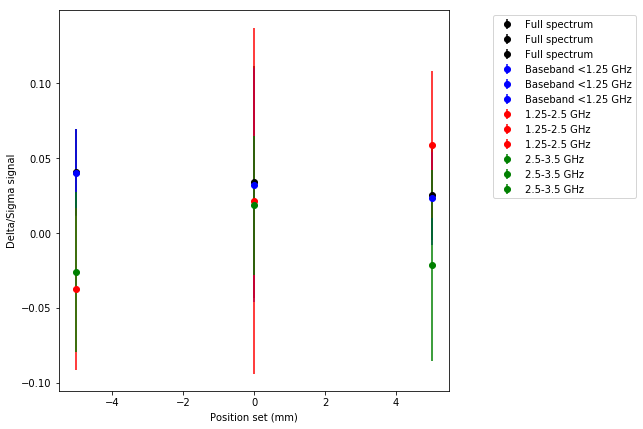

In [230]:
# no intensity normalisation
fig, ax = plt.subplots(1, figsize=(7,7))
def errordata(position, filter_str):
    mean = np.mean(epdf[filter_str].loc[epdf['position_set']==position])
    devsta = np.std(epdf[filter_str].loc[epdf['position_set']==position])
    return mean, devsta

for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma'), fmt='o', label='Full spectrum', color='k')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter1'), fmt='o', label='Baseband <1.25 GHz', color='b')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter2'), fmt='o', label='1.25-2.5 GHz', color='r')
for k in [0, -5, 5]:
    ax.errorbar(k, *errordata(k, 'delta/sigma_filter3'), fmt='o', label='2.5-3.5 GHz', color='g')
# for k in [0, -5, 5]:
#     ax.errorbar(k, *errordata(k, 'delta/sigma_filter4'), fmt='o', label='3.5-7 GHz', color='c')


ax.set_xlabel('Position set (mm)')
ax.set_ylabel('Delta/Sigma signal')

# ax.plot(epdf['position_set'],epdf['delta/sigma_filter1'],'.', label='Baseband <1.25 GHz')
# ax.plot(epdf['position_set'],epdf['delta/sigma_filter2'],'.', label='1.25-2.5 GHz')
# ax.plot(epdf['position_set'],epdf['delta/sigma_filter3'],'.', label='2.5-3.5 GHz')
# ax.plot(epdf['position_set'],epdf['delta/sigma_filter4'],'.', label='3.5-7 GHz')



ax.legend(frameon=True,bbox_to_anchor=(1.1,1))

# Conclusions of tonight:

The spectrum of the electrons + protons is dominated by the electrons up to 1.25 GHz.

**BUT** in the band 1.25 - 2.5 GHz it looks that the electron signal is dominant ! 
--> let's try with time gating ...
